In [12]:
import numpy as np
# TODO: Clean up these scipy imports
import scipy.constants as sc
import scipy.signal as ss
from scipy.optimize import line_search, minimize, fmin_cg
import matplotlib.pyplot as plt
from fte import fte
from gradFte import gradFte

## PCFM Waveform

In [13]:
# Number of waveforms to generate
nWaveforms = 1
# Waveform length in samples
M = 900
# Oversampling factor
K = 3
# Number of code values
N = int(M/K)
# Randomly generate a code sample matrix for each waveform
minAlpha = -sc.pi/K
maxAlpha = sc.pi/K
x0 = minAlpha + (maxAlpha - minAlpha) * np.random.rand(N,nWaveforms)
# Rectangular shaping filter with time support [0,Tp) = [0:K]
g = np.ones((K,1)) / K
g = np.concatenate((g,np.zeros((M-K,1))),axis=0)
# Construct an M x N basis matrix where each column is a basis function. This is
# NOT a basis in the mathematical sense; each column is equal to the previous
# column delayed by K samples
B = np.zeros((M,N))
for ii in range(N):
  B[:,ii] = np.cumsum(np.roll(g,ii*K))

## Frequency domain metric

In [14]:
# Normalized full-width bandwidth
bw = 0.5
# Convert to standard deviation
# https://en.wikipedia.org/wiki/Full_width_at_half_maximum
sigma = bw/(2*np.sqrt(2*np.log(2)))
# Convert from standard deviation to Matlab's weird width factor
# https://www.mathworks.com/help/signal/ref/gausswin.html#References
alpha = 1 / (2*sigma)
sigma = (2*M-1-1)/(2*alpha)
# Create the template vector
u = abs(ss.windows.gaussian(2*M-1,sigma))**2
# u[10*np.log10(u) <= -50] = 0
# Sample rate
fs = 200e6
# Frequency axis for plotting
freqStep = 2*fs/(2*M-1)
freqAxis = np.arange(-fs,fs,freqStep)

## Optimize

In [21]:
# Define a lambda function for the call to minimize() below
g = lambda x,B,u : gradFte(x,B,u) 
# print(fte(x0,B,u))
# # FIXME: Line search fails here
# res = minimize(fte, x0, jac=g,args=(B,u), options={'maxiter': 100, 'disp': True})
# xopt = res.x[:,np.newaxis]

# Manually do heavy ball gradient descent until I can get the scipy line search
# to converge
# Heavy ball parameter
beta = 0.9
# Initial guess
x = x0
# Initial gradient
pk = -g(x,B,u)
# Minimum error
Jmin = -np.inf
# Number of iterations
nIterations = int(5e3)
for ii in range(nIterations):
  J = fte(x,B,u)
  print(f'Iteration {ii}: {J}')
  # If the current guess gives the minimum error, it is the current optimal code
  if J < Jmin:
    Jmin = J
    xopt = x
  mu_k = 0.25
  x = x + mu_k*pk
  pk = -g(x,B,u)+beta*pk

Iteration 0: [21.36959968]
Iteration 1: [21.36710113]
Iteration 2: [21.36174139]
Iteration 3: [21.35280162]
Iteration 4: [21.33949312]
Iteration 5: [21.32116642]
Iteration 6: [21.29742052]
Iteration 7: [21.26813784]
Iteration 8: [21.23349351]
Iteration 9: [21.21796882]
Iteration 10: [21.19500839]
Iteration 11: [21.16300969]
Iteration 12: [21.12405868]
Iteration 13: [21.11411197]
Iteration 14: [21.14315786]
Iteration 15: [21.16012007]
Iteration 16: [21.16610013]
Iteration 17: [21.16277696]
Iteration 18: [21.15204721]
Iteration 19: [21.13593152]
Iteration 20: [21.11651132]
Iteration 21: [21.09578677]
Iteration 22: [21.07545332]
Iteration 23: [21.05667167]
Iteration 24: [21.03992958]
Iteration 25: [21.02505525]
Iteration 26: [21.01137223]
Iteration 27: [20.99793071]
Iteration 28: [20.98373544]
Iteration 29: [20.96791395]
Iteration 30: [20.94980673]
Iteration 31: [20.92899316]
Iteration 32: [20.90528332]
Iteration 33: [20.87870614]
Iteration 34: [20.84951435]
Iteration 35: [20.81820961]
It

## Plot the optimization result

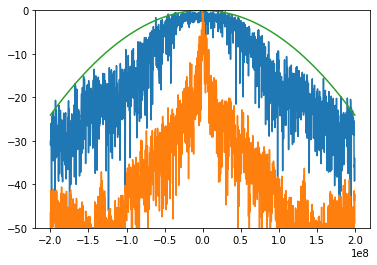

In [16]:
s = np.exp(1j*B@xopt)
s0 = np.exp(1j*B@x0)
sBar = np.concatenate((s, np.zeros((M-1, s.shape[1]))))
sBar0 = np.concatenate((s0, np.zeros((M-1, s.shape[1]))))
sfBar = np.fft.fftshift(np.fft.fft(sBar, axis=0))
sfBar = sfBar / max(abs(sfBar))
sfBar0 = np.fft.fftshift(np.fft.fft(sBar0, axis=0))
sfBar0 = sfBar0 / max(abs(sfBar0))
plt.plot(freqAxis, 10*np.log10(abs(sfBar)**2))
plt.plot(freqAxis, 10*np.log10(abs(sfBar0)**2))
plt.plot(freqAxis, 10*np.log10(u))
plt.ylim([-50,0])
plt.show()
